In [1]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import requests
from io import StringIO
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pickle

In [2]:
# Step 2: Download All Nifty 50 Stock Symbols Directly from NSE
nifty_url = "https://nsearchives.nseindia.com/content/indices/ind_nifty50list.csv"
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) Chrome/120.0.0.0 Safari/537.36"
}
session = requests.Session()
session.headers.update(headers)
session.get("https://www.nseindia.com", timeout=5)  # Warm-up for cookies
response = session.get(nifty_url, timeout=10)
nifty50 = pd.read_csv(StringIO(response.content.decode('utf-8')))
symbols = list(nifty50['Symbol'])

In [3]:
# Step 3: Download Historical Data for All Nifty 50 Stocks from Yahoo Finance
import yfinance as yf
data = {}
for symbol in symbols:
    print(f"Downloading {symbol}...")
    ticker = yf.Ticker(f"{symbol}.NS")
    history = ticker.history(start="2022-01-01", end=None)  # Last 3 years
    history['Symbol'] = symbol
    data[symbol] = history

# Combine all into one DataFrame
df = pd.concat(data.values())
df.reset_index(inplace=True)
df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Symbol
0,2022-01-03 00:00:00+05:30,1709.948677,1729.913051,1708.151834,1714.091309,1094708,0.0,0.0,ADANIENT
1,2022-01-04 00:00:00+05:30,1722.675965,1724.921957,1696.971833,1715.937988,1191189,0.0,0.0,ADANIENT
2,2022-01-05 00:00:00+05:30,1718.932791,1741.542472,1699.517484,1712.394409,1583598,0.0,0.0,ADANIENT
3,2022-01-06 00:00:00+05:30,1706.954008,1720.779313,1672.615260,1710.048462,1615375,0.0,0.0,ADANIENT
4,2022-01-07 00:00:00+05:30,1716.836485,1727.717094,1686.490611,1696.073486,1295933,0.0,0.0,ADANIENT
...,...,...,...,...,...,...,...,...,...
46728,2025-11-17 00:00:00+05:30,243.970001,244.779999,242.690002,244.050003,6559062,0.0,0.0,WIPRO
46729,2025-11-18 00:00:00+05:30,242.929993,244.000000,240.300003,240.899994,4730012,0.0,0.0,WIPRO
46730,2025-11-19 00:00:00+05:30,241.199997,246.850006,240.539993,246.070007,13298452,0.0,0.0,WIPRO
46731,2025-11-20 00:00:00+05:30,247.500000,247.800003,245.710007,246.259995,6705862,0.0,0.0,WIPRO


In [4]:
# Step 4: Data Preprocessing & Feature Engineering
# Example for a single symbol; repeat or loop for all stocks as needed
df.head()
df.tail()
symbol_to_analyze = symbols[0]
stock_df = df[df['Symbol']==symbol_to_analyze].copy()
stock_df['SMA_10'] = stock_df['Close'].rolling(window=10).mean()
stock_df['SMA_50'] = stock_df['Close'].rolling(window=50).mean()
stock_df = stock_df.dropna()


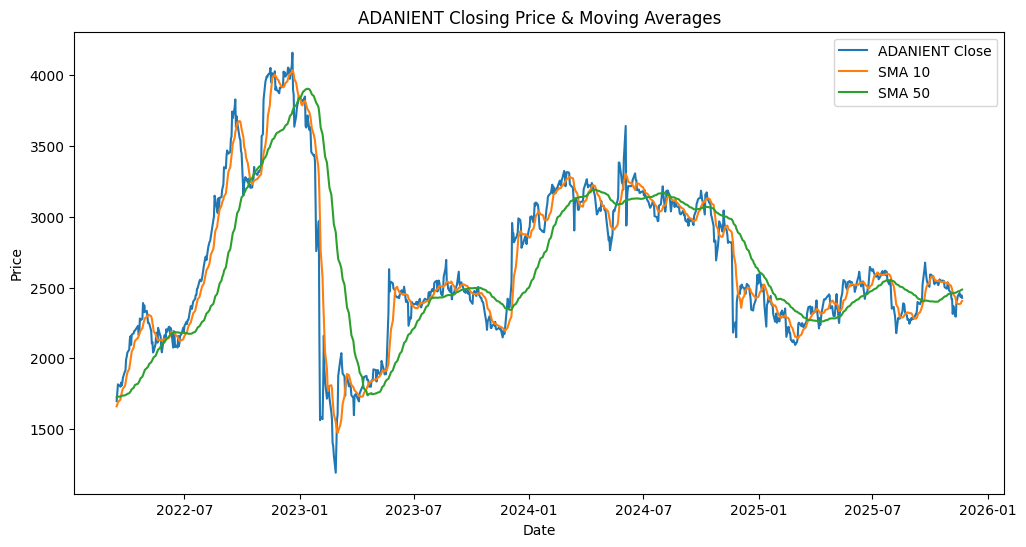

C:\Users\KRISHNA\AppData\Local\Temp\ipykernel_20896\697294060.py:15: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  stock_df['Month'] = stock_df['Date'].dt.to_period('M')


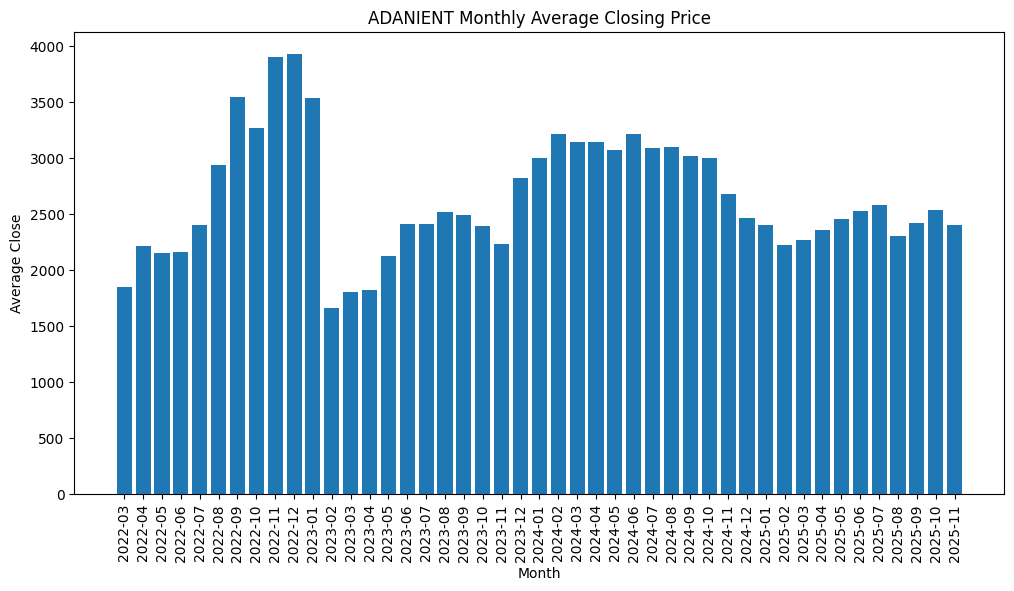

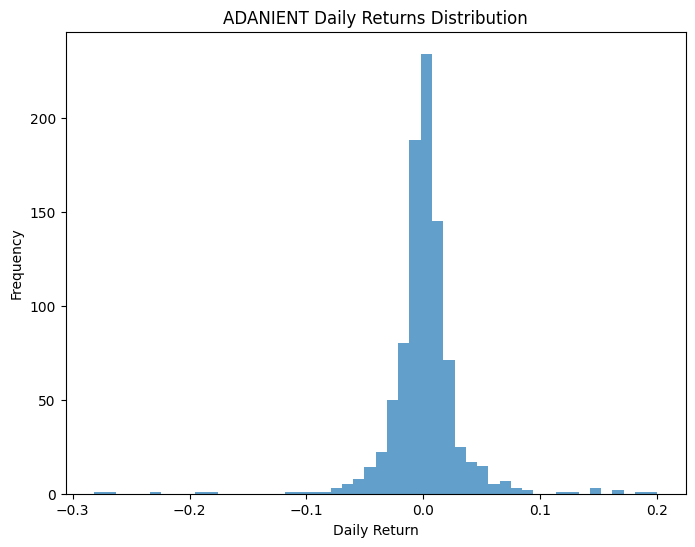

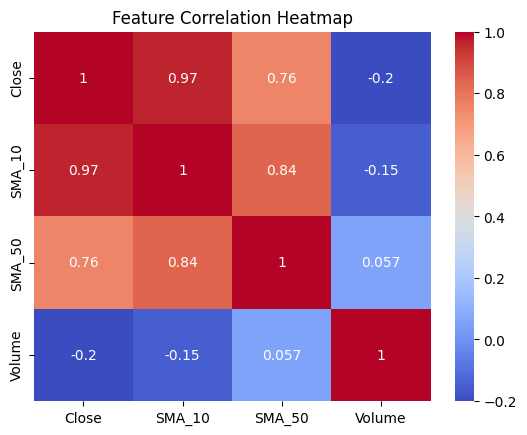

In [5]:
# Step 5: Data Visualization Separately

## Line Graph: Closing Price with Moving Averages
plt.figure(figsize=(12, 6))
plt.plot(stock_df['Date'], stock_df['Close'], label=f'{symbol_to_analyze} Close')
plt.plot(stock_df['Date'], stock_df['SMA_10'], label='SMA 10')
plt.plot(stock_df['Date'], stock_df['SMA_50'], label='SMA 50')
plt.title(f'{symbol_to_analyze} Closing Price & Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## Bar Graph: Monthly Mean of Close Price
stock_df['Month'] = stock_df['Date'].dt.to_period('M')
bar_data = stock_df.groupby('Month')['Close'].mean().reset_index()
plt.figure(figsize=(12,6))
plt.bar(bar_data['Month'].astype(str), bar_data['Close'])
plt.xlabel('Month')
plt.ylabel('Average Close')
plt.title(f'{symbol_to_analyze} Monthly Average Closing Price')
plt.xticks(rotation=90)
plt.show()

## Histogram: Daily Returns Distribution
stock_df['Daily_Return'] = stock_df['Close'].pct_change()
plt.figure(figsize=(8,6))
plt.hist(stock_df['Daily_Return'].dropna(), bins=50, alpha=0.7)
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.title(f'{symbol_to_analyze} Daily Returns Distribution')
plt.show()

## Correlation Heatmap on Features
features_for_corr = ['Close', 'SMA_10', 'SMA_50', 'Volume']
sns.heatmap(stock_df[features_for_corr].corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()


In [6]:
# Step 6: Data Preparation for Modeling
features = ['SMA_10', 'SMA_50']
X = stock_df[features]
y = stock_df['Close'].shift(-1)
X = X.iloc[:-1]
y = y.iloc[:-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
# Step 7: Build and Train Models
models = {
    'LinearRegression': LinearRegression(),
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(random_state=42)
}
for name, model in models.items():
    model.fit(X_train, y_train)


In [8]:
# Step 8: Predict and Evaluate Models
results = {}  # To store evaluation metrics for each model

for name, model in models.items():
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = np.mean(np.abs(y_test - y_pred))
    results[name] = {'MAE': mae, 'RMSE': np.sqrt(mse)}

results_df = pd.DataFrame(results).T
print(results_df)

                         MAE        RMSE
LinearRegression   66.298257   83.586871
DecisionTree      133.027837  174.722518
RandomForest       90.490012  110.114187


                         MAE        RMSE
LinearRegression   66.298257   83.586871
DecisionTree      133.027837  174.722518
RandomForest       90.490012  110.114187


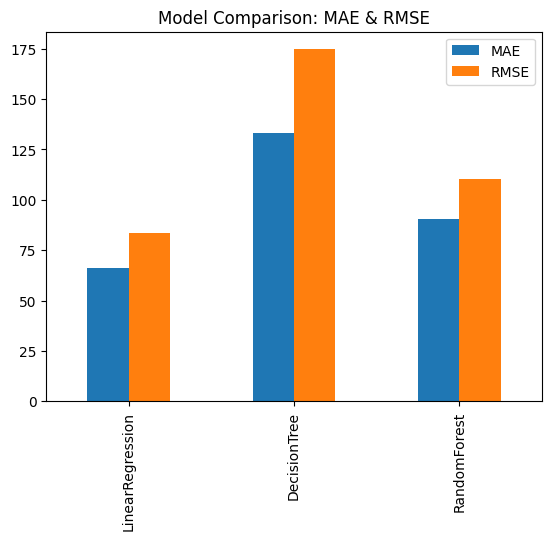

In [9]:
# Step 9: Model Comparison - Error Metrics Visualization
result_df = pd.DataFrame(results).T
print(result_df)
result_df[['MAE', 'RMSE']].plot(kind='bar', title='Model Comparison: MAE & RMSE')
plt.show()

In [10]:
#step 10 :- 
best_model_name = result_df['RMSE'].idxmin()
best_model = models[best_model_name]
with open(f'best_nifty_model_{symbol_to_analyze}.pkl', 'wb') as f:
    pickle.dump(best_model, f)
print(f'Best model for {symbol_to_analyze} ({best_model_name}) saved as best_nifty_model_{symbol_to_analyze}.pkl')


Best model for ADANIENT (LinearRegression) saved as best_nifty_model_ADANIENT.pkl


In [11]:
#step 11:- 
import ipywidgets as widgets
from IPython.display import display

# Load back the best model
with open(f'best_nifty_model_{symbol_to_analyze}.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# --- FUNCTION TO PREDICT NEXT DAY PRICE ---
def predict_next_day_price():
    # Get the last row of your dataframe
    last_row = stock_df.iloc[-1:].copy()

    # Prepare features SMA_10, SMA_50
    feature_row = last_row[['SMA_10', 'SMA_50']].values

    # Scale the features using the original scaler
    feature_row_scaled = scaler.transform(feature_row)

    # Predict using the saved model
    predicted_price = loaded_model.predict(feature_row_scaled)[0]

    return round(predicted_price, 2)


# --- Create the button ---
predict_button = widgets.Button(
    description='Predict Next Day Price',
    button_style='success',
    layout=widgets.Layout(width='250px')
)

output_area = widgets.Output()

# --- Button click event ---
def on_button_clicked(b):
    with output_area:
        output_area.clear_output()
        prediction = predict_next_day_price()
        print(f"📈 Predicted Next-Day Price for {symbol_to_analyze}: {prediction}")

predict_button.on_click(on_button_clicked)

# Display the button and output area
display(predict_button, output_area)




Button(button_style='success', description='Predict Next Day Price', layout=Layout(width='250px'), style=Butto…

Output()